# Worch vs Torch: training

In [1]:
import torch
import worch
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
torch.set_grad_enabled(False)
%load_ext autoreload
%autoreload 2

# Functions

In [2]:
def compare_weights(wnet, tnet):
    j = 0
    i = 1
    while j < len(wnet.module_list):
        ww = wnet[j].params[0]
        wb = wnet[j].params[1]
        tw = tnet[j].weight
        tb = tnet[j].bias
        if not ww.allclose(tw):
            return f'weight{i}', ww, tw
        if not wb.allclose(tb):
            return f'bias{i}', wb, tb
        i += 1
        j += 2
    return None

In [3]:
def compare_gradients(wnet, tnet):
    j = len(wnet.module_list)-1
    i = 1
    while j < len(wnet.module_list):
        ww = wnet[j].params[0].grad
        wb = wnet[j].params[1].grad
        tw = tnet[j].weight.grad
        tb = tnet[j].bias.grad
        if not ww.allclose(tw):
            return f'weight{i}', ww, tw
        if not wb.allclose(tb):
            return f'bias{i}', wb, tb
        i += 1
        j += 2
    return None

In [4]:
def train_worch(model, x, y, criterion, optimizer):
    model.train()
    yp = model(x)
    loss = criterion(yp, y)
    optimizer.zero_grad()
    criterion.backward() # call on module not tensor
    optimizer.step()
    return loss.cpu().detach().item(), yp

In [5]:
def train_torch(model, x, y, criterion, optimizer):
    model.train()
    torch.set_grad_enabled(True)
    yp = model(x)
    loss = criterion(yp, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    torch.set_grad_enabled(False)
    return loss.cpu().detach().item(), yp

In [6]:
def eval_model(model, x, y, criterion):
    model.eval()
    yp = model(x)
    loss = criterion(yp, y)
    return loss.cpu().detach().item()

# Load data

In [7]:
class Options:
    def __init__(self):
        self.n_samples = 15000
        self.n_features = 72
        self.n_targets = 3
        self.n_test = 0.2
        self.n_val = 0.2
        self.n_epochs = 250
        self.batch_size = 72
        self.lr = 0.02
        self.hidden_sizes = [self.n_features, 32, 8, self.n_targets]
        self.init_as_torch = False
opt = Options()

In [8]:
X, Y = datasets.make_regression(n_samples=opt.n_samples,
                                n_features=opt.n_features,
                                n_targets=opt.n_targets,
                                noise=35,
                                bias=0.2568541)
X_, X_test, Y_, Y_test = train_test_split(
    X, Y, test_size=opt.n_test, shuffle=True
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_, Y_, test_size=opt.n_val, shuffle=True
)

In [9]:
def make_torch(x):
    return torch.from_numpy(x).float().requires_grad_(False)

In [10]:
sc = StandardScaler().fit(X_)
X_train = make_torch(sc.transform(X_train))
Y_train = make_torch(Y_train)/100
X_val = make_torch(sc.transform(X_val))
Y_val = make_torch(Y_val)/100
X_test = make_torch(sc.transform(X_test))
Y_test = make_torch(Y_test)/100

In [11]:
X_train.shape, Y_train.shape

(torch.Size([9600, 72]), torch.Size([9600, 3]))

# Models

In [12]:
wmodules = []
tmodules = []
for i in range(len(opt.hidden_sizes[1:])):
    wmod = [worch.nn.Linear(opt.hidden_sizes[i], opt.hidden_sizes[i+1])]
    tmod = [torch.nn.Linear(opt.hidden_sizes[i], opt.hidden_sizes[i+1])]
    if opt.init_as_torch:
        wmod[-1].params[0] = tmod[-1].state_dict()['weight'].clone()
        wmod[-1].params[1] = tmod[-1].state_dict()['bias'].clone()
    if i < len(opt.hidden_sizes)-2:
        wmod.append(worch.nn.ReLU())
        tmod.append(torch.nn.ReLU())
    wmodules.extend(wmod)
    tmodules.extend(tmod)
wnet = worch.nn.Sequential(*wmodules)
tnet = torch.nn.Sequential(*tmodules)
tnet

Sequential(
  (0): Linear(in_features=72, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=3, bias=True)
)

In [13]:
j = 0
while True:
    try:
        print('Linear',j)
        print('wwstd',wnet[j].params[0].std())
        print('twstd',tnet[j].weight.std())
        print('wwmean',wnet[j].params[0].mean())
        print('twmean',tnet[j].weight.mean())
        print('wbstd',wnet[j].params[1].std())
        print('tbstd',tnet[j].bias.std())
        print('wbmean',wnet[j].params[1].mean())      
        print('tbmean',tnet[j].bias.mean())
        print('same weight', wnet[j].params[0].allclose(tnet[j].weight))
        print('same bias', wnet[j].params[1].allclose(tnet[j].bias))
        j += 2
        print()
    except:
        break

Linear 0
wwstd tensor(0.1363)
twstd tensor(0.0673)
wwmean tensor(0.0033)
twmean tensor(0.0008)
wbstd tensor(0.2319)
tbstd tensor(0.0750)
wbmean tensor(0.0300)
tbmean tensor(-0.0105)
same weight False
same bias False

Linear 2
wwstd tensor(0.2257)
twstd tensor(0.1015)
wwmean tensor(0.0099)
twmean tensor(0.0008)
wbstd tensor(0.4729)
tbstd tensor(0.0793)
wbmean tensor(-0.0275)
tbmean tensor(-0.0362)
same weight False
same bias False

Linear 4
wwstd tensor(0.4324)
twstd tensor(0.2116)
wwmean tensor(0.0833)
twmean tensor(0.0389)
wbstd tensor(0.6613)
tbstd tensor(0.0844)
wbmean tensor(-0.2198)
tbmean tensor(-0.2375)
same weight False
same bias False

Linear 6


# Losses

In [14]:
wcrit = worch.nn.MSELoss()
wcrit.register_previous_module(wnet)
tcrit = torch.nn.MSELoss()

# Optimizers

In [15]:
woptim = worch.optim.SGD(wnet.parameters(), lr=opt.lr)
toptim = torch.optim.SGD(tnet.parameters(), lr=opt.lr)

# Training loop

In [16]:
w_trlosses = []
w_valosses = []
t_trlosses = []
t_valosses = []
j = 0
for epoch in range(1, opt.n_epochs+1):
    # Train
    wnet.train()
    tnet.train()
    wlosses = []
    tlosses = []
    for k, b in enumerate(range(0, X_train.shape[0], opt.batch_size)):
        x = X_train[b:b+opt.batch_size]
        y = Y_train[b:b+opt.batch_size]
        wloss, wyp = train_worch(wnet, x.clone(), 
                                 y.clone(), wcrit, 
                                 woptim)
        tloss, typ = train_torch(tnet, x.clone(), 
                                 y.clone(), tcrit, 
                                 toptim)
        wlosses.append(wloss)
        tlosses.append(tloss)
    w_trlosses.append(torch.mean(torch.Tensor(wlosses)))
    t_trlosses.append(torch.mean(torch.Tensor(tlosses)))
    # Val
    wnet.eval()
    tnet.eval()
    wlosses = []
    tlosses = []
    for b in range(0, X_test.shape[0], opt.batch_size):
        x = X_test[b:b+opt.batch_size]
        y = Y_test[b:b+opt.batch_size]
        wloss = eval_model(wnet, x, y, wcrit)
        tloss = eval_model(tnet, x, y, tcrit)
        wlosses.append(wloss)
        tlosses.append(tloss)
    w_valosses.append(torch.mean(torch.Tensor(wlosses)))
    t_valosses.append(torch.mean(torch.Tensor(tlosses)))
    if epoch==1 or epoch % 100 == 0:
        print('[torch@({}/{})] train: {}, val: {}'.format(
            epoch, opt.n_epochs, t_trlosses[-1], t_valosses[-1]
        ))
        print('[worch@({}/{})] train: {}, val: {}\n-'.format(
            epoch, opt.n_epochs, w_trlosses[-1], w_valosses[-1]
        ))

[torch@(1/250)] train: 3.54221773147583, val: 2.5386977195739746
[worch@(1/250)] train: 1.0950359106063843, val: 0.32036903500556946
-
[torch@(100/250)] train: 0.1171184778213501, val: 0.13379694521427155
[worch@(100/250)] train: 0.12081274390220642, val: 0.14609786868095398
-
[torch@(200/250)] train: 0.11366958171129227, val: 0.1350567638874054
[worch@(200/250)] train: 0.11839313060045242, val: 0.148220494389534
-


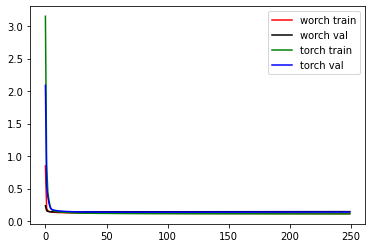

In [17]:
n = torch.arange(opt.n_epochs)
plt.plot(n, w_trlosses, 'r', label='worch train')
plt.plot(n, w_valosses, 'k-', label='worch val')
plt.plot(n, t_trlosses, 'g', label='torch train')
plt.plot(n, t_valosses, 'b-', label='torch val')
plt.legend()
plt.rcParams['figure.figsize'] = (14,8)
plt.show()

# Trash

In [ ]:
w_trlosses = []
w_valosses = []
t_trlosses = []
t_valosses = []
j = 0
# opt.n_epochs = 1
for epoch in range(1, opt.n_epochs+1):
#     print('epoch',epoch)
    # Train
    wnet.train()
    tnet.train()
    wlosses = []
    tlosses = []
    for k, b in enumerate(range(0, X_train.shape[0], opt.batch_size)):
    #     b = 10
    #     k = 1
        x = X_train[b:b+opt.batch_size]
        y = Y_train[b:b+opt.batch_size]
        # Debug ...
        if opt.init_as_torch:
            res = compare_weights(wnet, tnet)
#             if res is not None:
#                 print('WEIGHTS')
#                 print('batch', k, '/', X_train.shape[0]//opt.batch_size)
#                 print('x,y', x.shape, y.shape)
#                 print(res[0])
#                 print('worch:')
#                 print(res[1].shape)
#                 print(res[1])
#                 print('torch:')
#                 print(res[2].shape)
#                 print(res[2])
#                 _ = input()
#             else:
#                 print('WEIGHTS OK')
    #         wloss, wyp = train_worch(wnet, x.clone(), 
    #                                  y.clone(), wcrit, 
    #                                  woptim)
    #         tloss, typ = train_torch(tnet, x.clone(), 
    #                                  y.clone(), tcrit, 
    #                                  toptim)
        # Debug
    #     ww = wnet[-1].params[0].grad.clone()
    #     tw = tnet[-1].weight.detach().grad.clone()
    #     print(ww, tw)
        # WORCH
        wyp = wnet(x)
        wwloss = wcrit(wyp, y)
        woptim.zero_grad()
        wcrit.backward() # call on module not tensor
        woptim.step()
        wloss = wwloss.cpu().detach().item()
        # TORCH
        torch.set_grad_enabled(True)
        typ = tnet(x)
        ttloss = tcrit(typ, y)
        toptim.zero_grad()
        ttloss.backward()
        toptim.step()
        torch.set_grad_enabled(False)
        tloss = ttloss.cpu().detach().item()
#         # Debug
#         ww = wnet[-1].params[0].grad.clone()
# #         print('ww',ww)
#         tw = tnet[-1].weight.grad.clone()
#         wb = wnet[-1].params[1].grad.clone()
#         tb = tnet[-1].bias.grad.clone()
        # Debug
#         if opt.init_as_torch:
#             if not wyp.allclose(typ):
#                 print('OUTPUT')
#                 print('batch', k, '/', X_train.shape[0]//opt.batch_size)
#                 print('x,y', x.shape, y.shape)
#                 print('worch:')
#                 print(wyp.shape)
#                 print(wyp)
#                 print('torch:')
#                 print(typ.shape)
#                 print(typ)
#             else:
#                 print('OUPTUT OK')
        # Debug ...
#         if opt.init_as_torch:
#             res = compare_gradients(wnet, tnet)
#             if res is not None:
#                 print('GRAD')
#                 print('batch', k, '/', X_train.shape[0]//opt.batch_size)
#                 print('x,y', x.shape, y.shape)
#                 print(res[0])
#                 print('worch:')
#                 print(res[1].shape)
#                 print(res[1])
#                 print('torch:')
#                 print(res[2].shape)
#                 print(res[2])
#             else:
#                 print('GRAD OK')
        wlosses.append(wloss)
        tlosses.append(tloss)
    w_trlosses.append(torch.mean(torch.Tensor(wlosses)))
    t_trlosses.append(torch.mean(torch.Tensor(tlosses)))
    # Val
#     wlosses = []
#     tlosses = []
#     for b in range(0, X_train.shape[0], opt.batch_size):
#         x = X_train[b:b+opt.batch_size]
#         y = Y_train[b:b+opt.batch_size]
#         wloss = eval_model(wnet, x, y, wcrit)
#         tloss = eval_model(tnet, x, y, tcrit)
#         wlosses.append(wloss)
#         tlosses.append(tloss)
#     w_valosses.append(torch.mean(torch.Tensor(wlosses)))
#     t_valosses.append(torch.mean(torch.Tensor(tlosses)))
    if epoch==1 or epoch % 100 == 0:
        t_valosses = ['prout']
        w_valosses = ['prout']
        print('[torch@({}/{})] train: {}, val: {}'.format(
            epoch, opt.n_epochs, t_trlosses[-1], t_valosses[-1]
        ))
        print('[worch@({}/{})] train: {}, val: {}\n-'.format(
            epoch, opt.n_epochs, w_trlosses[-1], w_valosses[-1]
        ))

In [ ]:
j = len(wnet.module_list)
wnet.module_list
last_input = X_train[b:b+opt.batch_size]
for i in range(j-2):
    last_input = wnet[i](last_input)

In [ ]:
ttloss, wwloss

In [ ]:
wyp.shape, y.shape

In [ ]:
gloss = (wyp-y)*0.5
torch.mm(gloss.T, last_input)

In [ ]:
ww, tw

In [ ]:
gloss

In [ ]:
wb, tb

In [ ]:
wb / tb

In [ ]:
opt.batch_size

In [ ]:
0.5*0.75

In [ ]:
0.375*4

In [ ]:
plt.plot(torch.arange(x.shape[0]), x)

In [ ]:
wnet.training, wcrit.training, tnet.training, tcrit.training

In [ ]:
wnet[0].training